In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import time
import nupic

In [2]:
from nupic.encoders import RandomDistributedScalarEncoder
from nupic.encoders.date import DateEncoder
from nupic.algorithms.spatial_pooler import SpatialPooler
from nupic.algorithms.temporal_memory import TemporalMemory

from scipy.stats import norm

from __future__ import division

In [3]:
help(nupic.encoders)

Help on package nupic.encoders in nupic:

NAME
    nupic.encoders

FILE
    c:\users\carlo\appdata\local\conda\conda\envs\ipykernel_py2\lib\site-packages\nupic\encoders\__init__.py

DESCRIPTION
    # ----------------------------------------------------------------------
    # Numenta Platform for Intelligent Computing (NuPIC)
    # Copyright (C) 2013, Numenta, Inc.  Unless you have an agreement
    # with Numenta, Inc., for a separate license for this software code, the
    # following terms and conditions apply:
    #
    # This program is free software: you can redistribute it and/or modify
    # it under the terms of the GNU Affero Public License version 3 as
    # published by the Free Software Foundation.
    #
    # This program is distributed in the hope that it will be useful,
    # but WITHOUT ANY WARRANTY; without even the implied warranty of
    # MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
    # See the GNU Affero Public License for more details.
    #
    # You sh

In [4]:
# Import data
Data = pd.read_csv('ambient_temperature_system_failure.csv', parse_dates=True, index_col='timestamp')

In [5]:
Data = Data.resample('H').bfill().interpolate()

In [6]:
# Value Encoder Resoltion
Res = Data.std()[0]/5
RDSE = RandomDistributedScalarEncoder(resolution=Res)

In [7]:
# We ecndoe now the datas
TODE = DateEncoder(timeOfDay=(21,1))
WENDE = DateEncoder(weekend=21)

In [8]:
# Spatial Pooler Parameters
encoder_width = RDSE.getWidth() #+ TODE.getWidth()# + WENDE.getWidth()
pooler_out = 2024

In [9]:
encoder_width

400

In [10]:
SP = SpatialPooler(inputDimensions=(encoder_width), 
                   columnDimensions=(pooler_out), 
                   potentialPct=0.8, 
                   globalInhibition=True,
                   numActiveColumnsPerInhArea=pooler_out//50,
                   boostStrength = 1.0,
                   wrapAround = False
                  )
TM = TemporalMemory(columnDimensions=(pooler_out,), 
                    cellsPerColumn=5)


In [11]:
start = time.time()

active_columns = np.zeros(pooler_out)
# Spatial pooler learning
for x in range(len(Data)):
    e_val = RDSE.encode(Data['value'][x])
    #e_tod = TODE.encode(Data.index[x])
    #e_wend = WENDE.encode(Data.index[x])
    encoder = np.concatenate([e_val])
    SP.compute(encoder, True, active_columns)
    
end = time.time()
print(end - start)

83.3199999332


In [19]:
start = time.time()

A_score = np.zeros(len(Data))
Data['Anomaly'] = 0.0
for x in range(len(Data)):
    e_val = RDSE.encode(Data['value'][x])
    #e_tod = TODE.encode(Data.index[x])
    #e_wend = WENDE.encode(Data.index[x])
    encoder = np.concatenate([e_val])
    SP.compute(encoder, False, active_columns)
    col_index = active_columns.nonzero()[0]
    TM.compute(col_index, learn=True)
    if x > 0:
        inter = set(col_index).intersection(Prev_pred_col)
        inter_l = len(inter)
        active_l = len(col_index)
        A_score[x] = 1-(inter_l/active_l)
        Data.iat[x,-1] =  A_score[x]
    Prev_pred_col = list(set(x//5 for x in TM.getPredictiveCells()))
    
end = time.time()
print(end - start)

214.371000051


In [13]:
from scipy.stats import norm
W = 72
W_prim = 5
eps = 1e-6

Data['Anomaly_Likelihood'] = 0.0
AL_score = np.zeros(len(Data))
for x in range(len(Data)):
    if x > 0:
        W_vec = A_score[max(0, x-W): x]
        W_prim_vec = A_score[max(0, x-W_prim): x]
        AL_score[x] = 1 - 2*norm.sf(abs(np.mean(W_vec)-np.mean(W_prim_vec))/max(np.std(W_vec), eps))
        Data.iat[x,-1] =  AL_score[x]
    

In [14]:
Data['Anomaly_flag'] = Data['Anomaly_Likelihood'] > 0.95

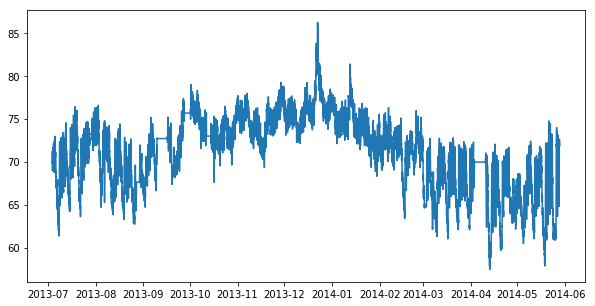

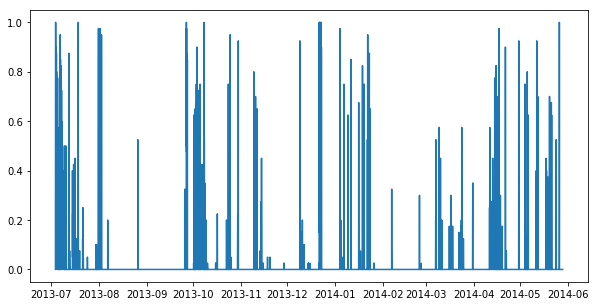

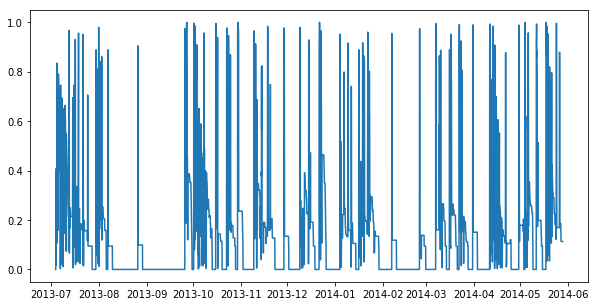

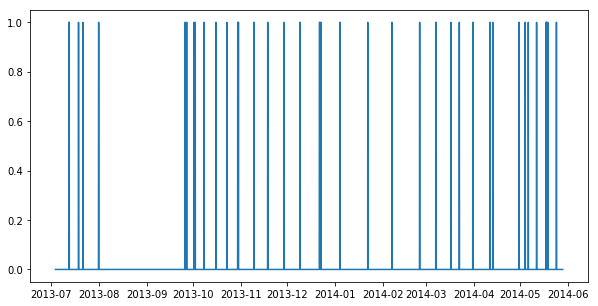

In [15]:
plt.figure(figsize=(10,5))
plt.plot(Data['value'])
plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly'])
plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_Likelihood'])
plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_flag'])

In [16]:
import datetime as dt # Imports dates library 
a = dt.datetime(2014, 1, 20) # Fixes the start date 
b = dt.datetime(2014, 3, 1) # Fixes the start date 

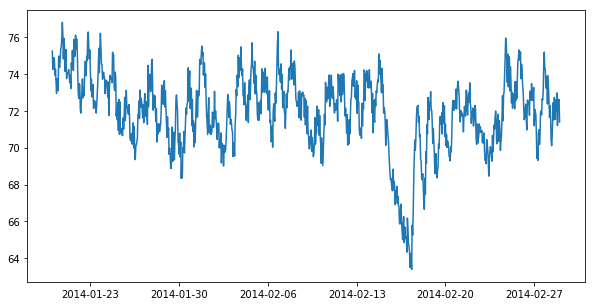

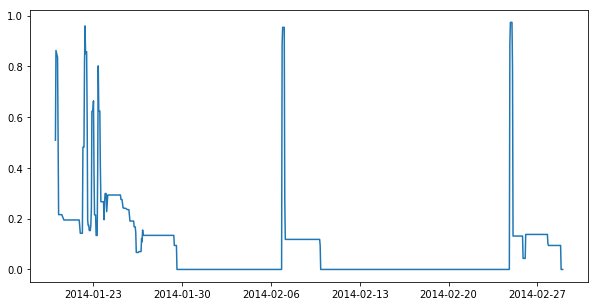

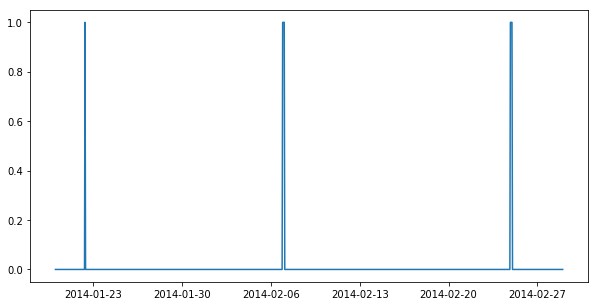

In [17]:
plt.figure(figsize=(10,5))
plt.plot(Data['value'][a:b])
plt.figure(figsize=(10,5))
# plt.plot(Data['Anomaly'][a:b])
# plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_Likelihood'][a:b])
plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_flag'][a:b])

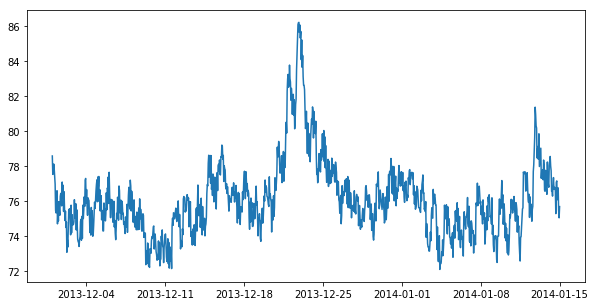

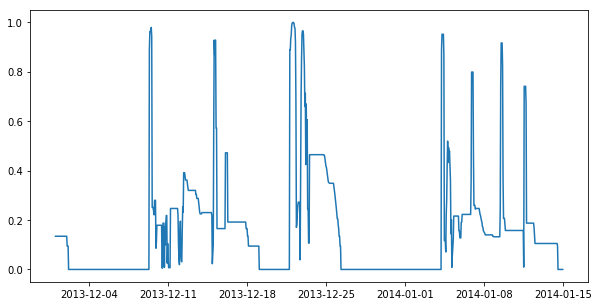

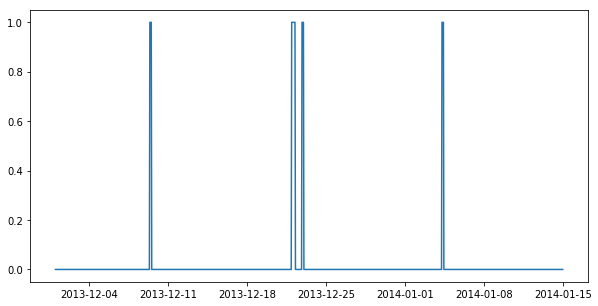

In [18]:
a = dt.datetime(2013, 12, 1) # Fixes the start date 
b = dt.datetime(2014, 1, 15) # Fixes the start date 
plt.figure(figsize=(10,5))
plt.plot(Data['value'][a:b])
plt.figure(figsize=(10,5))
# plt.plot(Data['Anomaly'][a:b])
# plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_Likelihood'][a:b])
plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_flag'][a:b])

# Second execution

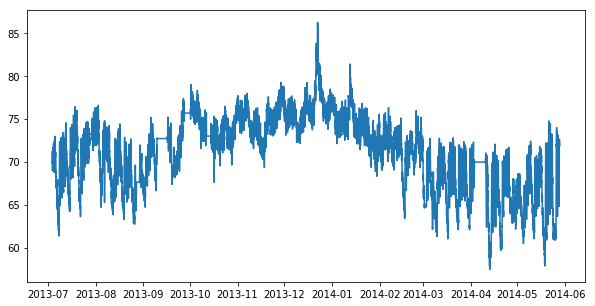

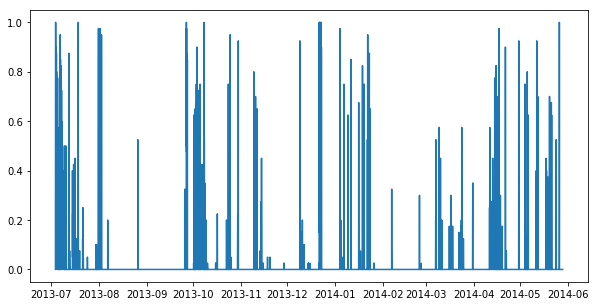

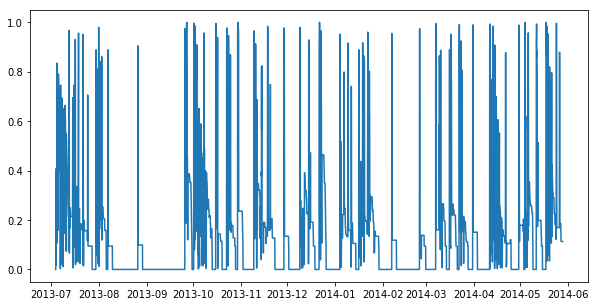

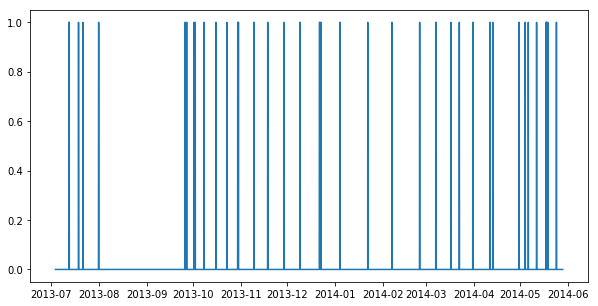

In [15]:
plt.figure(figsize=(10,5))
plt.plot(Data['value'])
plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly'])
plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_Likelihood'])
plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_flag'])

In [16]:
import datetime as dt # Imports dates library 
a = dt.datetime(2014, 1, 20) # Fixes the start date 
b = dt.datetime(2014, 3, 1) # Fixes the start date 

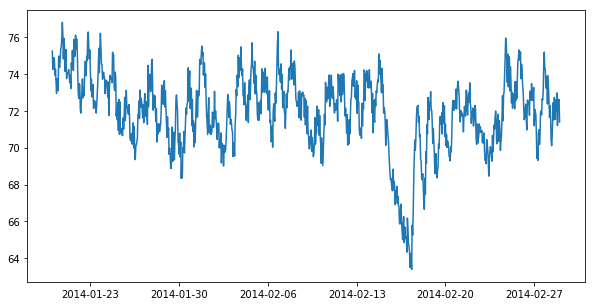

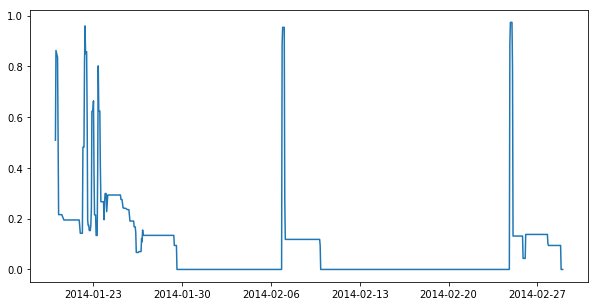

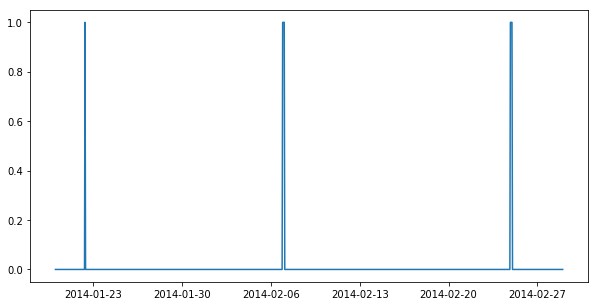

In [17]:
plt.figure(figsize=(10,5))
plt.plot(Data['value'][a:b])
plt.figure(figsize=(10,5))
# plt.plot(Data['Anomaly'][a:b])
# plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_Likelihood'][a:b])
plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_flag'][a:b])

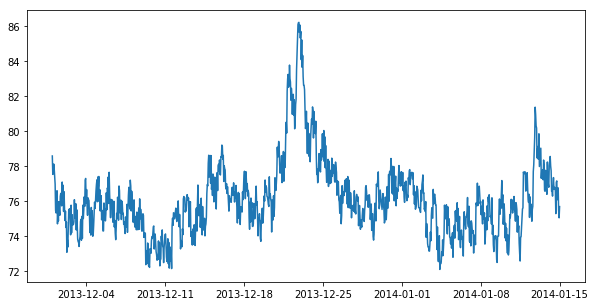

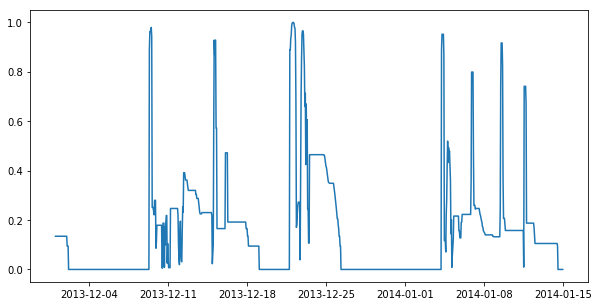

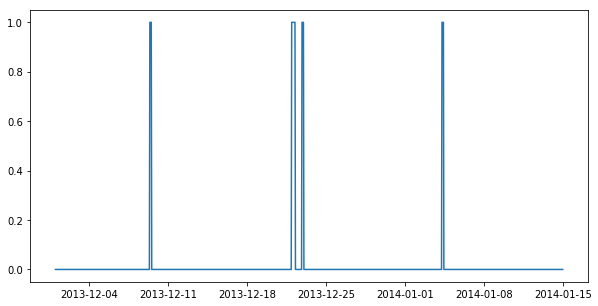

In [18]:
a = dt.datetime(2013, 12, 1) # Fixes the start date 
b = dt.datetime(2014, 1, 15) # Fixes the start date 
plt.figure(figsize=(10,5))
plt.plot(Data['value'][a:b])
plt.figure(figsize=(10,5))
# plt.plot(Data['Anomaly'][a:b])
# plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_Likelihood'][a:b])
plt.figure(figsize=(10,5))
plt.plot(Data['Anomaly_flag'][a:b])